# Case 2.
**Neural Networks for Machine Learning Applications**<br>
28.02.2022<br>
Daniel Ridzon, Melany Marcias, Ha Do<br>
Metropolia University of Applied Sciences

## Task description
Your task is to use convolutional neural networks to create a binary classifier for x-ray chest
images.

## Introduction
In this notebook, we are showing 3 of our CNN models for predicting pneumonia from chest xray scans.  
In the end we compare them and choose the one with best results.  
We are loading data for each model separately, as each model was created by different team member, so not all commands would work properly.

## Setup


In [77]:
# libraries import
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import seaborn as sns
import shutil
import tensorflow as tf
import time

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from warnings import simplefilter



print("tensorflow", tf.__version__)

tensorflow 2.7.0


## Constants

In [2]:
# Training settings
batch_size = 128
aug_batch_size = 16
img_size = 128
random_seed = 42

class_names = ["NORMAL", "PNEUMONIA"]
VERBOSE = 0  # 0 to turn of debugging messages while training.
EPOCHS = 45  # number of epochs per model training.

# Ignore tf performance warnings
simplefilter(action='ignore', category=FutureWarning)

## Loading the dataset

In [3]:
# Define location of the training data.
train_dir = './data/chest-xray-pneumonia/chest_xray/train'  # on Kaggle change to '../input/chest-xray-pneumonia/chest_xray/train'
val_dir = './data/chest-xray-pneumonia/chest_xray/val'
test_dir = './data/chest-xray-pneumonia/chest_xray/test'

**Bellow we define and run 3 different CNN models, their comparsion is at the end of the notebook.**

## CNN Model 1

### Balance of the data
Here we check if the data on the input are in correct balance, by counting number of cases per each dataset.

In [4]:
train_normal_cnt = len(next(os.walk(os.path.join(train_dir, "NORMAL")))[2])
train_pneumonia_cnt = len(next(os.walk(os.path.join(train_dir, "PNEUMONIA")))[2])

val_normal_cnt = len(next(os.walk(os.path.join(val_dir, "NORMAL")))[2])
val_pneumonia_cnt = len(next(os.walk(os.path.join(val_dir, "PNEUMONIA")))[2])

test_normal_cnt = len(next(os.walk(os.path.join(test_dir, "NORMAL")))[2])
test_pneumonia_cnt = len(next(os.walk(os.path.join(test_dir, "PNEUMONIA")))[2])

print(f"Train dataset: {train_normal_cnt} normal, {train_pneumonia_cnt} pneumonia")
print(f"Validation dataset: {val_normal_cnt} normal, {val_pneumonia_cnt} pneumonia")
print(f"Test dataset: {test_normal_cnt} normal, {test_pneumonia_cnt} pneumonia")

Train dataset: 1349 normal, 3883 pneumonia
Validation dataset: 8 normal, 8 pneumonia
Test dataset: 234 normal, 390 pneumonia


#### Balance observations
From results above we can see that the folder with validation data has small amount of data (just 8 samples from each class), so we decided, that we will merge test and validation folders together and then we will use 80:20 split. 

### Rebalancing the data folders
Code bellow copies all data from validation folder to the train folder. Data are then splitted by correct ratio during the Image generator phase.  
(If this codes runs again, data wont be copied again, so we wont get any duplicates).

In [5]:
# Copiing validation samples to the train folder.
normal_files = os.listdir(os.path.join(val_dir, "NORMAL"))
pneumonia_files = os.listdir(os.path.join(val_dir, "PNEUMONIA"))

for file in normal_files:
    shutil.copyfile(os.path.join(os.path.join(val_dir, "NORMAL"), file), os.path.join(os.path.join(train_dir, "NORMAL"), file))

for file in pneumonia_files:
    shutil.copyfile(os.path.join(os.path.join(val_dir, "PNEUMONIA"), file), os.path.join(os.path.join(train_dir, "PNEUMONIA"), file))

train_normal_cnt = len(next(os.walk(os.path.join(train_dir, "NORMAL")))[2])
train_pneumonia_cnt = len(next(os.walk(os.path.join(train_dir, "PNEUMONIA")))[2])
print(f"Train dataset: {train_normal_cnt} normal, {train_pneumonia_cnt} pneumonia")

Train dataset: 1349 normal, 3883 pneumonia


### Class weights
As we see above, class distribution is not event, so we have created dictionary with class weights, which will fix this issue during the training phase.

In [6]:
# Balance of the dataset.
class_weights = {
    0: test_pneumonia_cnt / (test_pneumonia_cnt + test_normal_cnt),
    1: test_normal_cnt / (test_pneumonia_cnt + test_normal_cnt)
}

### CNN model

#### Data augumentation layer
Here we add data augumentation layer to increase the amount of images in the training dataset and to improve models capability to recognize more inconsistent input data. We didn't used shear or flipping setting, because rentgen scanner shouldn't produce mistakes of this magnitude. But we have used, rotation and zoom, as the person could not be aligned always 100% accurately at the rentgen scanner.

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


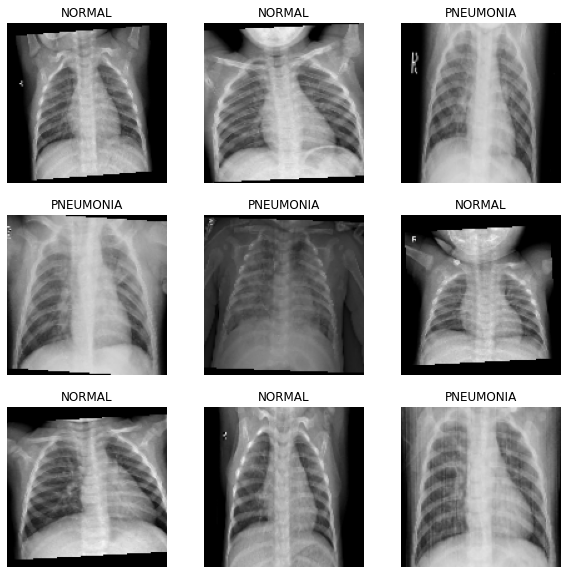

In [7]:
# Define augumented images generator. (https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)
datagen = ImageDataGenerator(
    rotation_range=4,
    zoom_range=0.2,
    fill_mode="constant",
    validation_split=0.2
)

# Test data generator is defined separately, as it does not modify the data.
test_datagen = ImageDataGenerator()

# Create augumented images iterator.
train_it = datagen.flow_from_directory(
    train_dir,
    subset = "training",
    seed = random_seed,
    target_size=(img_size, img_size),
    batch_size=aug_batch_size,
    class_mode="binary"
)

val_it = datagen.flow_from_directory(
    train_dir,
    subset = "validation",
    seed = random_seed,
    target_size=(img_size, img_size),
    batch_size=aug_batch_size,
    class_mode="binary"
)

test_it = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=aug_batch_size,
    class_mode="binary"
)

# Visualize the augumented images for checking settings.
plt.figure(figsize=(10, 10))
for i in range(9):
    batch = train_it.next()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0][0].astype('uint8'))
    plt.title(class_names[int(batch[1][0])])
    plt.axis("off")

#### Defining the CNN model
In the first example we have used Sequential CNN model with 4 Conv2D and MaxPooling2D layers.  
After flattening we have added Droupout layer of 25% and one hidden Dense layer with 256 neurons.

In [47]:
# Defining the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 64)      

#### Compiling the model
Here we have to define our own Specificity metrics as it is not implemented in Keras by default.  
Sensitivity is implemented in Keras under alternative name Recall.

In [48]:
def specificity(y_true, y_pred):
    """
    source: https://stackoverflow.com/a/55688340
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred

    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)

    specificity = tn / (tn + fp + K.epsilon())

    return specificity

In [49]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[tf.metrics.BinaryAccuracy(name="binary_accuracy"), tf.keras.metrics.Recall(name="recall"), specificity]
)

#### Plot of the CNN model
*(Graphical model view wasn't possible to run on the local machine.)*

In [50]:
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


#### Training the model

In [51]:
# Save the start time of the algorithm.
start_time = time.time()

history = model.fit(
    train_it,
    steps_per_epoch=32,
    epochs=EPOCHS,
    validation_data=val_it,
    validation_steps=8,
    class_weight=class_weights,
    verbose=VERBOSE
)


# Save the total time of the training
total_time_1 = time.time() - start_time
print(total_time_1)

582.9013521671295


#### Saving the model
Here we saved the model, so we can load it later without running the training again.

In [52]:
model.save("case_2_model_v_1.h5")

### Plotting the training results
Bellow we plot Sensitivity and Specificity graphs of the training.  
Comparsion with other models and more in depth review of the results is at the end, after the last model. 

In [53]:
def plot_history(history):
    """
    Method for plotting sensitivity and specificity of the model training history.
    """
    sens = history.history['recall']
    val_sens = history.history['val_recall']

    spec = history.history['specificity']
    val_spec = history.history['val_specificity']

    epochs = range(1, len(sens) + 1)

    plt.plot(epochs, sens, 'bo', label='Training sensitivity')
    plt.plot(epochs, val_sens, 'b', label='Validation sensitivity')
    plt.title('Training and validation sensitivity')
    plt.legend()
    plt.figure()

    plt.plot(epochs, spec, 'bo', label='Training specificity')
    plt.plot(epochs, val_spec, 'b', label='Validation specificity')
    plt.title('Training and validation specificity')
    plt.legend()

    plt.show()

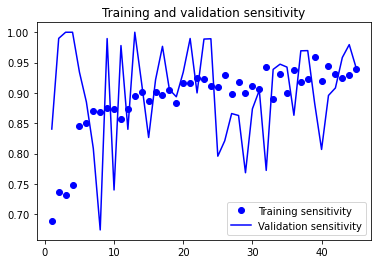

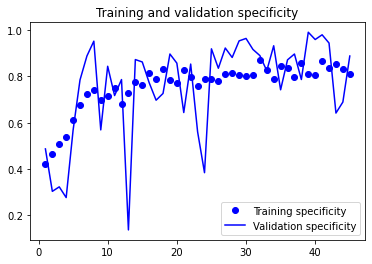

In [54]:
plot_history(history)

In [55]:
print(f"sensitivity: {history.history['val_recall'][-1]:.3f}")
print(f"specificity: {history.history['val_specificity'][-1]:.3f}")

sensitivity: 0.941
specificity: 0.889


### Model 1 observations - TODO
With first CNN model we have achieved validation sensitivity of 94% and validation specificity of 88%.

## CNN model 2

### Model 2 constants

In [17]:
# Define dataset folders location.
train_path = train_dir
test_path = test_dir
valid_path = val_dir

#Define some often used standard parameters

#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 

#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

### Data augumentation
Here we slightly modify input data, so the final model is more robust to unexpected changes.  

For this model we have used shear, zoom and horizontal_flip augumentation.

In [18]:
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split=0.2
)

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

#### Creating Image generator iterators

In [19]:
train = image_gen.flow_from_directory(
    train_path,
    subset = "training",
    seed = random_seed,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    shuffle=False,  #setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
    class_mode='binary',
    batch_size=batch_size
)

valid = image_gen.flow_from_directory(
    train_path,
    subset = "validation",
    seed = random_seed,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary', 
    batch_size=batch_size
)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


#### Display modified images

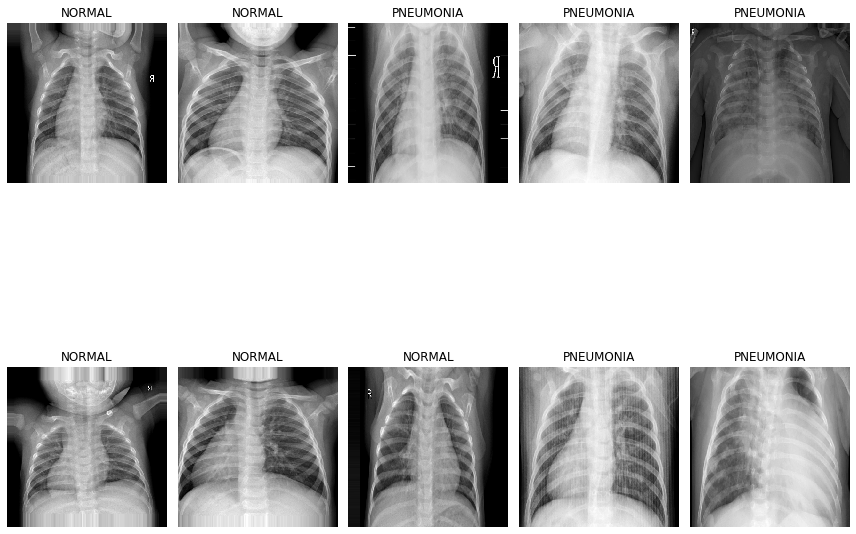

In [20]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

#### Defining the CNN model
In the second example we have used Sequential CNN model with 5 Conv2D and MaxPooling2D layers.  
After flattening we have 2 hidden dense layers - one with 128 and second with 64 neurons.

In [21]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_2.add(MaxPooling2D(pool_size = (2, 2)))
model_2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_2.add(MaxPooling2D(pool_size = (2, 2)))
model_2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_2.add(MaxPooling2D(pool_size = (2, 2)))
model_2.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_2.add(MaxPooling2D(pool_size = (2, 2)))
model_2.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_2.add(MaxPooling2D(pool_size = (2, 2)))
model_2.add(Flatten())
model_2.add(Dense(activation = 'relu', units = 128))
model_2.add(Dense(activation = 'relu', units = 64))
model_2.add(Dense(activation = 'sigmoid', units = 1))
model_2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [tf.metrics.BinaryAccuracy(name="binary_accuracy"), tf.keras.metrics.Recall(name="recall"), specificity]
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 60, 60, 32)      

#### CNN model plot

In [22]:
plot_model(model_2, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


#### Training params
Second CNN model uses early stopping for ending the fitting process, when there are no more improvements in loss metrics.  
Also it uses gradual learning rate reduction, which improves learning rate in the start but in the end it makes it smaller, so the model can find minimums more precisely in gradient descent.

In [23]:
# Define fit params.
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 5, verbose=1,factor=0.25, min_lr=0.0000001)
callbacks_list = [ early, learning_rate_reduction]

# Compute class weights
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))

#### Training the model 2

In [24]:
# Save the start time of the algorithm.
start_time = time.time()

history_2 = model_2.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=32,
    validation_data=valid,
    validation_steps=8,
    class_weight=cw,
    callbacks=callbacks_list,
    verbose=VERBOSE
)

# Save the total time of the training
total_time_2 = time.time() - start_time
print(total_time_2)


Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
2903.9517183303833


#### Save the model

In [25]:
model_2.save("case_2_model_v_2.h5")

#### Plot model metrics - TODO have metrics of all models together in the bottom

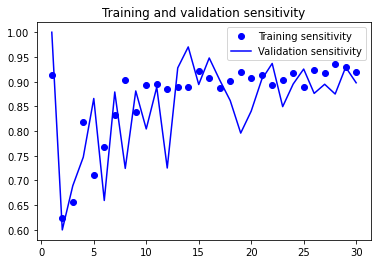

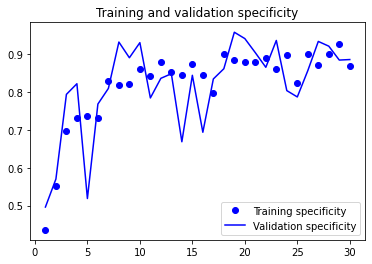

In [26]:
plot_history(history_2)

In [27]:
print(f"sensitivity: {history_2.history['val_recall'][-1]:.3f}")
print(f"specificity: {history_2.history['val_specificity'][-1]:.3f}")

sensitivity: 0.898
specificity: 0.886


### Model 2 observations
With second CNN model we have achieved validation sensitivity of 89% and validation specificity of 88%.


## CNN model 3

### Constants

In [29]:
img_width = 224
img_height = 224

### CNN model

#### Data augumentation
For this model we have used shear, zoom and horizontal flip augumentation.

In [30]:
# Image data generator for the train and validation set
image_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2
)

# Create Image Data Generator for the test set
test_data_gen = ImageDataGenerator(rescale = 1./255)

#### Creating Image generator iterators

In [31]:
# Loading the Images
train = image_gen.flow_from_directory(
    train_path,
    subset="training",
    seed=random_seed,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size= batch_size
)

valid = image_gen.flow_from_directory(
    train_path,
    subset="validation",
    seed=random_seed,
    target_size=(img_height, img_width),
    class_mode='binary', 
    batch_size=batch_size
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    shuffle=False, 
    class_mode='binary',
    batch_size=batch_size
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Display modified images

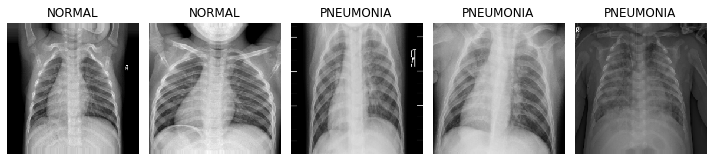

In [32]:
plt.figure(figsize=(10, 10))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest' )
        break
plt.tight_layout()
plt.show()

#### Defining the CNN model

In the third example we have used Sequential CNN model with 4 Conv2D and 3 MaxPooling2D layers.  
We have added dropout layers before the last Conv2D layer and also before flattening and output layer.  
After flattening we have 1 hidden dense layers - with 64 neurons.

In [33]:
model_3 = Sequential()

model_3.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = (224, 224, 3)))
model_3.add(Conv2D(64,(3,3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(layers.Dropout(0.25))
model_3.add(Conv2D(64,(3,3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))

model_3.add(layers.Dropout(0.25))

# as we go deeper into the models, we need to increase the number of channels because the closer we are, the least features we are able to process
model_3.add(Conv2D(128,(3,3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))

model_3.add(layers.Dropout(0.25))

model_3.add(Flatten())

model_3.add(Dense(64,activation='relu'))

model_3.add(layers.Dropout(0.5))

model_3.add(Dense(1,activation = 'sigmoid'))

model_3.compile(
    loss = keras.losses.binary_crossentropy,
    optimizer = 'adam',
    metrics = [tf.metrics.BinaryAccuracy(name="binary_accuracy"), tf.keras.metrics.Recall(name="recall"), specificity]
)

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 110, 110, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                 

#### CNN model plot

In [34]:
plot_model(model_3, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


#### Training the model 3

In [35]:
# Save the start time of the algorithm.
start_time = time.time()

history_3 = model_3.fit(
    train,
    epochs = EPOCHS,
    steps_per_epoch = 32,
    class_weight = class_weights,
    validation_data = valid,
    validation_steps = 8,
    verbose = VERBOSE
)

# Save the total time of the training
total_time_3 = time.time() - start_time
print(total_time_3)

3583.464877843857


#### Save the model

In [36]:
model.save("case_2_model_v_3.h5")

#### Plot model metrics

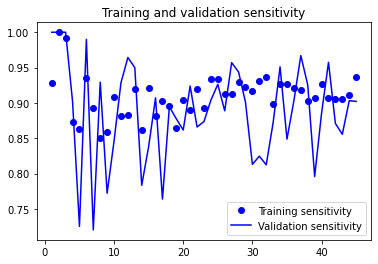

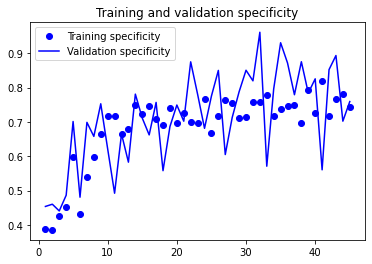

In [37]:
plot_history(history_3)

In [38]:
print(f"sensitivity: {history_3.history['val_recall'][-1]:.3f}")
print(f"specificity: {history_3.history['val_specificity'][-1]:.3f}")

sensitivity: 0.902
specificity: 0.759


### Model 3 observations
With third CNN model we have achieved validation sensitivity of 90% and validation specificity of 75%.


## Models result evaluation

### Basic metrics

In [56]:
print(f"First model has achieved on validation data overall accuracy of {history.history['val_binary_accuracy'][-1]*100:.1f}% sensitivity of {history.history['val_recall'][-1]*100:.1f}% and specificity of {history.history['val_specificity'][-1]*100:.1f}%.")
print(f"Second model has achieved on validation data overall accuracy of {history_2.history['val_binary_accuracy'][-1]*100:.1f}% sensitivity of {history_2.history['val_recall'][-1]*100:.1f}% and specificity of {history_2.history['val_specificity'][-1]*100:.1f}%.")
print(f"Third model has achieved on validation data overall accuracy of {history_3.history['val_binary_accuracy'][-1]*100:.1f}% sensitivity of {history_3.history['val_recall'][-1]*100:.1f}% and specificity of {history_3.history['val_specificity'][-1]*100:.1f}%.")

First model has achieved on validation data overall accuracy of 93.8% sensitivity of 94.1% and specificity of 88.9%.
Second model has achieved on validation data overall accuracy of 90.6% sensitivity of 89.8% and specificity of 88.6%.
Third model has achieved on validation data overall accuracy of 90.6% sensitivity of 90.2% and specificity of 75.9%.


### Training time

In [57]:
print(f"First model have been training for {total_time_1:.0f}s.")
print(f"Second model have been training for {total_time_2:.0f}s.")
print(f"Third model have been training for {total_time_3:.0f}s.")

First model have been training for 583s.
Second model have been training for 2904s.
Third model have been training for 3583s.


### Choosing the best model

For the final testing we have choosen the first CNN model, which have achieved highest sensitivity and specificity metrics. As a bonus this model have been training for the shortest time.

## Testing the final model

#### Load the trained model from the save file.

In [86]:
model = keras.models.load_model("case_2_model_v_1.h5", custom_objects={"specificity": specificity})

### Confusion matrix

39/39 [==============================] - 23s 164ms/step


<AxesSubplot:>

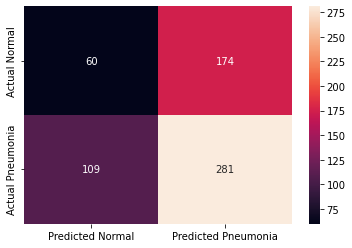

In [90]:
# Predicting classes on the test dataset
test_pred = model.predict(test_it, verbose=1)

# Rounding float predicted values to one of the target classes.
predictions = test_pred.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

# Plotting confusion matrix
cm = pd.DataFrame(data=confusion_matrix(test_it.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

#### Confusion matrix observations

Ideal confusion matrix should have most of the cases on the diagonal from top left to bottom right corner, then all predicted cases are correct.  
Our confusion matrix is far from perfect.

### Classification report

In [89]:
print(classification_report(y_true=test_it.classes, y_pred=predictions, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.43      0.31      0.36       234
   PNEUMONIA       0.64      0.75      0.69       390

    accuracy                           0.58       624
   macro avg       0.53      0.53      0.53       624
weighted avg       0.56      0.58      0.57       624



#### Classification report observations

Classification report displays most common statistics about the predicted data.  
The main values which to look for in the report are precision, recall and f1 score of the pneumonia class.  

Precision of pneumonia is 64% - that means 64% of predicted pneumonia cases are actually correct.  
Recall of pneumonia is 75% - that means our model discovered 75% of all actual pneumonia classes.  
F1 score of pneumonia class is 69%. F1 is combining both metrics mentioned above into one (it is mean average of them).  

All those metrics for pneumonia class are above 50% - that means our model is better then random model would be. Ideal metrics should be on 100%.

## Conclusion
Our best model doesn't produce optimal results, which would be usable in real medical use.  
Our results could be further improved by testing different CNN model configurations, increasing training time or adding more training data.